<a href="https://colab.research.google.com/github/alisterpage/CHEM3580-Jupyter-Notebooks/blob/main/homework%201/forcefield_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework - Looking Under the Hood of an MD Forcefield

For this homework exercise, you will decompose the individual terms that make up a MD forcefield. We will use a 'toy system' for this exercise - a (very short) MD simulation of a single alanine trimer.

To get started, run the code cell below to setup the Google Colab environment. (Expect it to take 1-2 minutes the first time you run it)

    

In [1]:
#@title Setup Environment
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge packmol openmm   -q 2>&1 >/dev/null

✨🍰✨ Everything looks OK!


In [2]:

from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
import re
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pdb_content = """\
REMARK *
REMARK   DATE:     8/ 5/ 9     14:44:19      CREATED BY USER: mjw
ATOM      1  N   ALA     1       0.024  -0.103  -0.101  1.00  0.00      AAL
ATOM      2  HT1 ALA     1       0.027  -1.132  -0.239  1.00  0.00      AAL
ATOM      3  HT2 ALA     1      -0.805   0.163   0.471  1.00  0.00      AAL
ATOM      4  HT3 ALA     1      -0.059   0.384  -1.019  1.00  0.00      AAL
ATOM      5  CA  ALA     1       1.247   0.375   0.636  1.00  0.00      AAL
ATOM      6  HA  ALA     1       0.814   0.861   1.495  1.00  0.00      AAL
ATOM      7  CB  ALA     1       2.057  -0.772   1.289  1.00  0.00      AAL
ATOM      8  HB1 ALA     1       3.136  -0.752   1.032  1.00  0.00      AAL
ATOM      9  HB2 ALA     1       1.990  -0.641   2.395  1.00  0.00      AAL
ATOM     10  HB3 ALA     1       1.656  -1.782   1.063  1.00  0.00      AAL
ATOM     11  C   ALA     1       1.956   1.579   0.036  1.00  0.00      AAL
ATOM     12  O   ALA     1       1.219   2.525  -0.201  1.00  0.00      AAL
ATOM     13  N   ALA     2       3.289   1.631  -0.202  1.00  0.00      AAL
ATOM     14  HN  ALA     2       3.939   0.868  -0.174  1.00  0.00      AAL
ATOM     15  CA  ALA     2       3.990   2.909  -0.215  1.00  0.00      AAL
ATOM     16  HA  ALA     2       3.742   3.440   0.695  1.00  0.00      AAL
ATOM     17  CB  ALA     2       3.662   3.802  -1.434  1.00  0.00      AAL
ATOM     18  HB1 ALA     2       4.192   4.778  -1.358  1.00  0.00      AAL
ATOM     19  HB2 ALA     2       3.956   3.311  -2.382  1.00  0.00      AAL
ATOM     20  HB3 ALA     2       2.577   4.027  -1.467  1.00  0.00      AAL
ATOM     21  C   ALA     2       5.487   2.654  -0.128  1.00  0.00      AAL
ATOM     22  O   ALA     2       5.889   1.489  -0.137  1.00  0.00      AAL
ATOM     23  N   ALA     3       6.275   3.733  -0.037  1.00  0.00      AAL
ATOM     24  HN  ALA     3       5.963   4.691  -0.028  1.00  0.00      AAL
ATOM     25  CA  ALA     3       7.707   3.802   0.068  1.00  0.00      AAL
ATOM     26  HA  ALA     3       8.160   3.418  -0.833  1.00  0.00      AAL
ATOM     27  CB  ALA     3       8.233   3.093   1.333  1.00  0.00      AAL
ATOM     28  HB1 ALA     3       9.342   3.149   1.356  1.00  0.00      AAL
ATOM     29  HB2 ALA     3       7.835   3.593   2.240  1.00  0.00      AAL
ATOM     30  HB3 ALA     3       7.923   2.030   1.332  1.00  0.00      AAL
ATOM     31  C   ALA     3       8.018   5.323   0.136  1.00  0.00      AAL
ATOM     32  OT1 ALA     3       7.032   6.119   0.127  1.00  0.00      AAL
ATOM     33  OT2 ALA     3       9.219   5.692   0.188  1.00  0.00      AAL
TER      34      ALA      3
END
"""

with open("ala_ala_ala.pdb", "w") as f:
    f.write(pdb_content)

You're ready to setup your simulation - execute the next code cell, which will define all of the necessary parameters for your simulation.

In [4]:
pdb = PDBFile('ala_ala_ala.pdb')
forcefield = ForceField('amber14-all.xml')
system = forcefield.createSystem(pdb.topology)

for i, f in enumerate(system.getForces()):
    f.setForceGroup(i)


integrator = VerletIntegrator(0.001*picoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.context.setVelocitiesToTemperature(300*kelvin)

# Perform local energy minimization
print("Minimizing energy...")
simulation.minimizeEnergy(maxIterations=1000)

Minimizing energy...


You're ready to run the simulation! Execute the next code cell to simulate 1000 steps of Newton's equations of motion, using the AMOEBA forcefield (we will use this more extensively in the workshops for this part of the course).

In [5]:
total_steps = 1000
report_interval = 10
ncols = 5  # total energy columns, we will only show 4 of them in col_order

# Prepare force names once
names = [f.getName() for f in system.getForces()]
nrows = (len(names) + ncols - 1) // ncols

# Pad to fill full column layout
while len(names) < nrows * ncols:
    names.append("")

# Column order for display: col0, col4, col1, col2
col_order = [0, 4, 1, 2]

# Print headers
# print("\nForce Field Components (kJ/mol):")
# for row in range(nrows):
#     headers = ["{:<10}".format("Step #")]
#     headers += [f"{names[col*nrows + row]:>22}" for col in col_order]
#     if row == 0:
#         headers += [f"{'Total PE':>22}", f"{'Total KE':>22}"]
#     print("".join(headers))

# Step and print values
for step in range(0, total_steps, report_interval):
    simulation.step(report_interval)

    # Get per-force energies
    energies = []
    for i in range(len(system.getForces())):
        state = simulation.context.getState(getEnergy=True, groups={i})
        energy = state.getPotentialEnergy().value_in_unit(kilojoules_per_mole)
        energies.append(energy)

    # Pad energies
    while len(energies) < nrows * ncols:
        energies.append("")

    # Get global state for total potential energy and temperature
    global_state = simulation.context.getState(getEnergy=True)
    total_PE = global_state.getPotentialEnergy().value_in_unit(kilojoules_per_mole)
    total_KE = global_state.getKineticEnergy().value_in_unit(kilojoules_per_mole)

    # # Print formatted rows
    # for row in range(nrows):
    #     values = [f"{step + report_interval:<10}"]
    #     values += [
    #         f"{energies[col*nrows + row]:22.5e}" if isinstance(energies[col*nrows + row], float)
    #         else f"{'':>22}"
    #         for col in col_order
    #     ]
    #     if row == 0:
    #         values += [f"{total_PE:22.5e}", f"{total_KE:22.5e}"]
    #     print("".join(values))

With your MD trajectory complete, run the next cell to generate the main result that you need to analyse for your first homework submission.

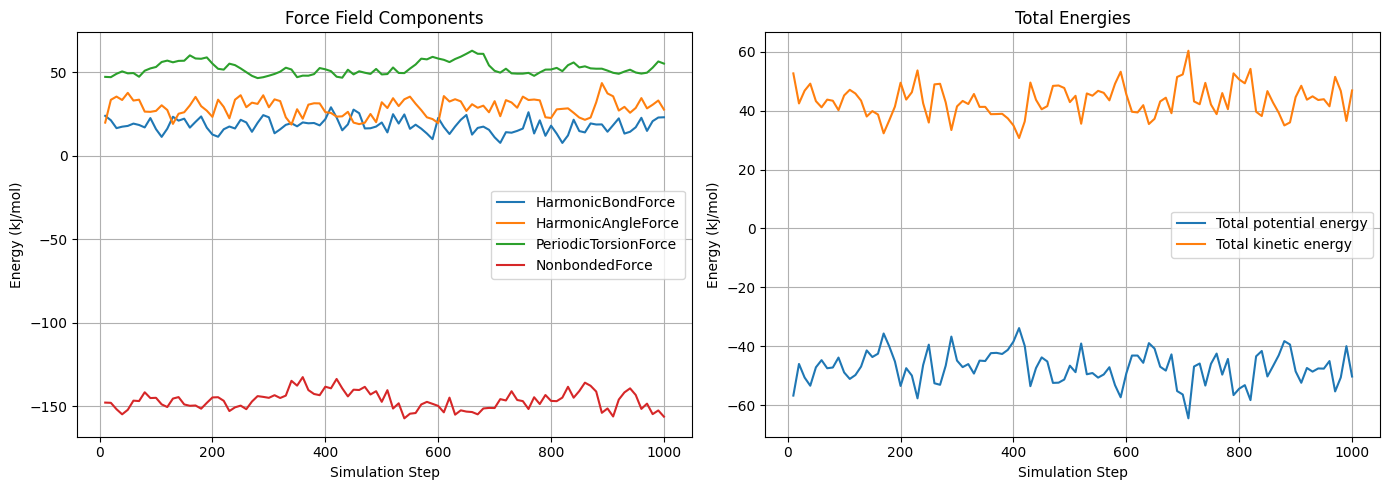

In [6]:
# Column order used in printout
col_order = [0, 4, 1, 2]
ncols = 5
nrows = (len(system.getForces()) + ncols - 1) // ncols

# Get and pad force names
names = [f.getName() for f in system.getForces()]
while len(names) < nrows * ncols:
    names.append("")

# Labels for the selected columns
column_labels = []
for col in col_order:
    idx = col * nrows
    column_labels.append(names[idx])

# Initialize data
step_numbers = []
force_group_energies = {label: [] for label in column_labels}
total_PE = []
total_KE = []

# Reset simulation
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy(maxIterations=1000)

# Collect data
for step in range(0, total_steps, report_interval):
    simulation.step(report_interval)
    step_number = step + report_interval
    step_numbers.append(step_number)

    # Per-force energies
    energies = []
    for i in range(len(system.getForces())):
        state = simulation.context.getState(getEnergy=True, groups={i})
        energy = state.getPotentialEnergy().value_in_unit(kilojoules_per_mole)
        energies.append(energy)

    while len(energies) < nrows * ncols:
        energies.append(np.nan)

    for col, label in zip(col_order, column_labels):
        idx = col * nrows
        force_group_energies[label].append(energies[idx])

    # Global energies
    state_global = simulation.context.getState(getEnergy=True)
    total_PE.append(state_global.getPotentialEnergy().value_in_unit(kilojoules_per_mole))
    total_KE.append(state_global.getKineticEnergy().value_in_unit(kilojoules_per_mole))

# Plotting in 2x1 grid (side-by-side)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharex=True)

# Left: Force group energies
for label in force_group_energies:
    ax1.plot(step_numbers, force_group_energies[label], label=label)
ax1.set_title("Force Field Components")
ax1.set_xlabel("Simulation Step")
ax1.set_ylabel("Energy (kJ/mol)")
ax1.legend()
ax1.grid(True)

# Right: Total PE and KE
ax2.plot(step_numbers, total_PE, label="Total potential energy", color='tab:blue')
ax2.plot(step_numbers, total_KE, label="Total kinetic energy", color='tab:orange')
ax2.set_title("Total Energies")
ax2.set_xlabel("Simulation Step")
ax2.set_ylabel("Energy (kJ/mol)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Questions

1. Why is the total NonbondedForce always negative? Explain your answer in terms of the physical interactions included in this term.
1. Why are the total Harmonic bond and angle energies always positive? Explain your answer in terms of the formulation of these two forcefield components.
1. Why is the total kinetic energy always positive?
1. How are the force field components related to the total potential energy, and the total kinetic energy?
1. What do you notice about the total potential and kinetic energy throughout the entire simulation? What fundamental universal principal is responsible for this?